# Explore Ngram Corpus

This notebook enables some preliminary exploration of the Ngram corpus. It provides some functionality for querying and visualisation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tools.ngram_creation import *
from tools.ngram_exploration import Corpus
from scipy.sparse import load_npz
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
from tqdm import tqdm
from collections import defaultdict
sns.set()

# Create Sparse Matrix

This notebook builds on `Create_Sparse_Matrices.ipynb`.

Uncomment the code below to merge all NLP level ngrams into one large sparse matrix. Warning: this operation requires quite some memory!

In [6]:
# handler = JSONHandler('../ngrams-all')
# save_to = '../sparse_ngrams'
# vocab = json.load(open(Path(save_to) / 'vocab.json'))
# corpus_proc = CorpusProcessor(handler,
#                               vocab = vocab, 
#                               save_to = save_to)

In [ ]:
# corpus_proc.merge_sparse_matrices('../newspaper_matrix/',
#                                   **{'npd_links_path' : './metadata/metadata.csv',
#                                      'npd_data_path' : './metadata/MPD_export_1846_1920_20221208_geo_coded_pob_pcir.csv'})

In [ ]:
#!ls -la /ngrams_datadrive_2/sparse_matrix_jisc

# Load Corpus and Prep Data

The line below loads the ngram corpus as one large sparse matrix with associated metadata.

In [3]:
corpus = Corpus.load('/Users/kasparbeelen/Documents/LwM/ES_data/unigram-matrix') #/ngrams_datadrive_2/sparse_matrix_jisc ../newspaper_matrix/

: 

In [ ]:
# this line of code will be replaced with a more appropriate simplfication of political labels
# for now we simple take the last label
#corpus.metadata['Leaning'] = corpus.metadata['S-POL'].apply(lambda x: str(x).split(';')[-1].strip())
path = 'data/PolLabelReclassification - label_reclassification.csv'
target_col = 'label_alt'
corpus.simplify_political_labels(path,target_col)

In [9]:
corpus.metadata['Leaning'].value_counts()#.sum()

liberal         101699
conservative     86191
nan              48061
neutral          45613
independent      36211
radical           2483
national          1102
religious          456
national            72
Name: Leaning, dtype: int64

In [11]:
corpus.counts.shape

(321888, 245750)

# Query Sparse Matrix

Define the query as a list of search terms.

In [108]:
query = ['machines','machines','engine','engines']
#query = ['bike','bicycle','bikes','bicycles']
query = ['drought']

We query the corpus for the selected keywords and add the results to the metadata dataframe as a 'hits' columns. The we compute the relative frequencies for each newspaper-month.

In [109]:
%time res = corpus.query(query) # query the ngrams corpus for all search terms 
corpus.metadata['hits'] = res # add results as new column with name hits
corpus.metadata['relative_frequency'] = corpus.metadata['hits'] / corpus.metadata['totals'] # compute relative frequency

CPU times: user 21.8 s, sys: 2.56 ms, total: 21.8 s
Wall time: 21.8 s


The cells below allow you to specify the query and select
- `timestep`, the temporal unit, e.g. year, month, decade
- `facet`, the dimension or facet, i.e. which variable to use for comparing the (relative) frequency
- `facet_values` which values to include in the comparison
- `start_at`. `end_at`: the date range

# Plot timelines (for a selected variable)

In [116]:
timestep = 'year' # define the time step, the temporal unit of analysis, mostly year
facet = 'Leaning'# define the facet i.e. 'COUNTY' | 'Leaning'
# set facet values
# if facet equals COUNTY, possible facet values are ['lancashire','dorsetshire']
facet_values = ['conservative','liberal','independent','neutral'] 
start_at, end_at = 1830,1920 # set the date range

In [117]:
# create the time fileter
time_filter = (corpus.metadata.year.between(start_at,end_at))

Plot the relative frequency for all observation within the selected date range.

<AxesSubplot:title={'center':'frequency of DROUGHT'}, xlabel='year', ylabel='relative_frequency'>

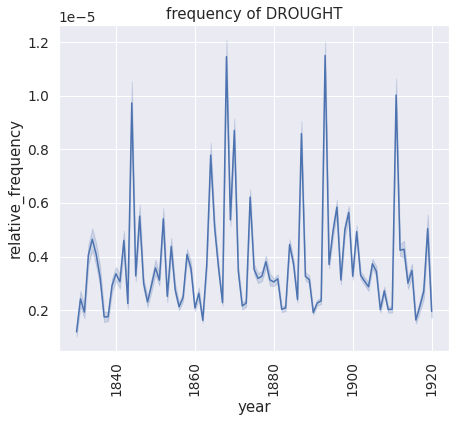

In [236]:
plt.figure(figsize=(7,6))
plt.xticks(rotation=90)
plt.title(f'frequency of {query[0].upper()}')
sns.set(font_scale= 1.25)
sns.lineplot(x=timestep,y='relative_frequency',data=corpus.metadata[time_filter])

<AxesSubplot:xlabel='year', ylabel='totals'>

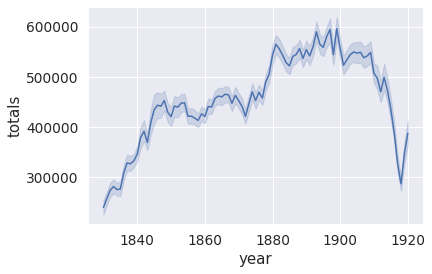

In [119]:
sns.lineplot(x=timestep,y='totals',data=corpus.metadata[time_filter])

Now, we filter the results down to the selected facet values.

In [120]:
facet_filter = (corpus.metadata[facet].isin(facet_values))
data = corpus.metadata[time_filter & facet_filter]

In [121]:
#corpus.metadata.Leaning

And plot the results!

<AxesSubplot:title={'center':'frequency of "DROUGHT" by political leaning'}, xlabel='year', ylabel='relative_frequency'>

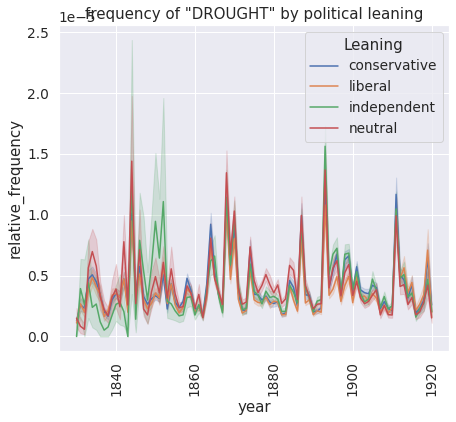

In [122]:
plt.figure(figsize=(7,6))
plt.xticks(rotation=90)
plt.title(f'frequency of "{query[0].upper()}" by political leaning')
sns.lineplot(x=timestep,y='relative_frequency',hue=facet,data=data,hue_order=facet_values)

You can also save the results as a csv table and use it for statistical analysis.

In [123]:
data.to_csv(f'./data/output_{query[0]}.csv')

In [238]:
corpus.metadata['M'] = corpus.metadata['month'].apply(lambda x: int(str(x).split('-')[-1]) )

<AxesSubplot:xlabel='M', ylabel='relative_frequency'>

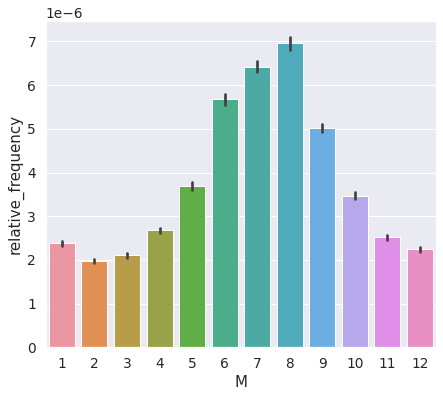

In [239]:
plt.figure(figsize=(7,6))
sns.barplot(x='M',y='relative_frequency',data=corpus.metadata)
#sns.boxplot(data=corpus.metadata, x="M", y="relative_frequency")

## Geographical Visualisation of Query Results

In [232]:
import datetime

geo_result = corpus.metadata.groupby(
        ['longitude','latitude','month'] # ,'year'
                ).apply(lambda x: (x.hits / x.totals)*1000000) # hits per million words

geo_result_df = geo_result.reset_index()
geo_result_df.columns = ['longitude','latitude','month','idx','rel_freq'] # 'year',
geo_result_df['rel_freq'] = geo_result_df['rel_freq'].astype(int)
geo_result_df['time'] = geo_result_df.month.apply(lambda x: str(datetime.datetime(year=int(x.split('-')[0]), month=int(x.split('-')[1]), day=1)))
geo_result_df.to_csv(f'data/output_kepler_{query[0]}.csv') # [geo_result_df.year.between(1780,1920)]


In [125]:
#geo_result_df[geo_result_df.year.between(1780,1920)].to_json(f'data/output_kepler_{query[0]}.json')

In [233]:
# taken from https://notebook.community/captainsafia/nteract/applications/desktop/example-notebooks/pandas-to-geojson
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}

    # loop through each row in the dataframe and convert each row to geojson format
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}

        # fill in the coordinates
        feature['geometry']['coordinates'] = [row[lon],row[lat]]

        # for each column, get the value and add it as a new feature property
        for prop in properties:
            feature['properties'][prop] = row[prop]
        
        # add this feature (aka, converted dataframe row) to the list of features inside our dict
        geojson['features'].append(feature)
    
    return geojson

In [234]:
cols = ['month', 'idx', 'rel_freq','time']
data = df_to_geojson(geo_result_df,cols) # [geo_result_df.year.between(1846,1920)]

In [235]:
import json
with open(f'data/output_kepler_{query[0]}.json', 'w') as f:
    json.dump(data, f)

# Fin.